<a href="https://colab.research.google.com/github/OtusTeam/Machine-Learning/blob/main/%D0%9C%D0%BE%D0%B4%D1%83%D0%BB%D1%8C%207%3A%20Bayesian%20Learning%2C%20PyMC/35_bayes_ab_04_show.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian A/B testing

### Imports

In [ ]:
import pandas as pd
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from IPython.core.pylabtools import figsize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Load Data

In [ ]:
df = pd.read_csv('sample_data/cookie_cats.csv')

In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


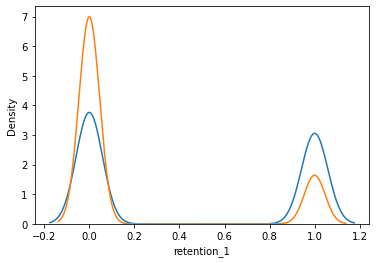

In [ ]:
site_A = df.loc[df['version'] == 'gate_30', :]
sns.kdeplot(site_A.loc[:, 'retention_1'])
sns.kdeplot(site_A.loc[:, 'retention_7'])

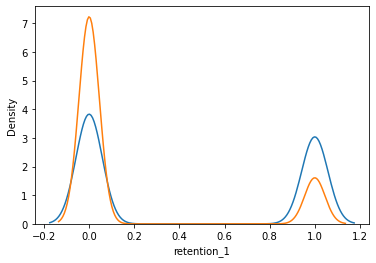

In [ ]:
site_B = df.loc[df['version'] == 'gate_40', :]
sns.kdeplot(site_B.loc[:, 'retention_1'])
sns.kdeplot(site_B.loc[:, 'retention_7'])

In [ ]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


In [ ]:
N_A = site_A.shape[0]
N_B = site_B.shape[0]

observations_A = df.loc[df['version'] == 'gate_30', 'retention_1'].values.astype(int)
observations_B = df.loc[df['version'] == 'gate_40', 'retention_1'].values.astype(int)

print('The number of users retrained after 1 day in variant A:', observations_A.sum())
print('The number of users retrained after 1 day in variant B:', observations_B.sum())

The number of users retrained after 1 day in variant A: 20034
The number of users retrained after 1 day in variant B: 20119


In [ ]:
df.groupby('version').mean()[['retention_1', 'retention_7']]

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


In [ ]:
# these two quantities are unknown to us. And you can assume the values
true_p_A = 0.45
true_p_B = 0.40

# Set up the pymc3 model. Assum Beta priors for p_A and p_B
with pm.Model() as model:
  p_A = pm.Beta('p_A', 11, 14) # 11 successes and 14 failures
  p_B = pm.Beta('p_B', 11, 14)

  # Define the deterministic delta function. This is our unknown of interest.
  delta = pm.Deterministic('delta', p_A - p_B)

  # Set ob observations, in this case we have two observation datasets (the two variants).
  # this is likelihood function where we use the prior distribution as our parameter in the likelihood function
  obs_A = pm.Bernoulli('obs_A', p_A, observed=observations_A)
  obs_B = pm.Bernoulli('obs_B', p_B, observed=observations_B)

  step = pm.Metropolis()
  # sample 20000 iterations and store the paths of all our variables, or 'traces'
  trace = pm.sample(20000, step=step) 
  # discard the first 1000 iterations
  burned_trace = trace[1000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
100%|██████████| 20500/20500 [01:08<00:00, 300.29it/s]
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
# these are the posterior distributions note these distributions are beta distributions sice the conjugate prior of bernoulli is beta
p_A_samples = burned_trace['p_A']
p_B_samples = burned_trace['p_B']
delta_samples = burned_trace['delta']

In [ ]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that variant A is worse than variant B.
print(f'Probability site A is WORSE than site B: {np.mean(delta_samples < 0):.3f}')
print(f'Probability site A is BETTER than site B: {np.mean(delta_samples > 0):.3f}')

Probability site A is WORSE than site B: 0.036
Probability site A is BETTER than site B: 0.964


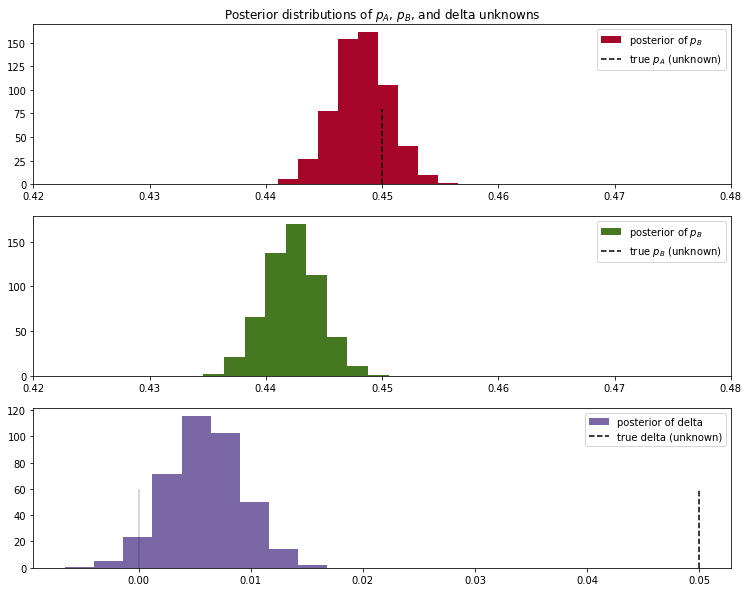

In [ ]:
figsize(12.5, 10)

# histogram of posteriors
ax = plt.subplot(311)

plt.xlim(.42, .48)
plt.hist(p_A_samples, histtype='stepfilled', label='posterior of $p_B$', color='#A60628', density=True)
plt.vlines(true_p_A, 0, 80, linestyle='--', label='true $p_A$ (unknown)')
plt.legend(loc='upper right')
plt.title('Posterior distributions of $p_A$, $p_B$, and delta unknowns')

ax = plt.subplot(312)
plt.xlim(.42, .48)
plt.hist(p_B_samples, histtype='stepfilled', label='posterior of $p_B$', color='#467821', density=True)
plt.vlines(true_p_B, 0, 80, linestyle='--', label='true $p_B$ (unknown)')
plt.legend(loc='upper right')

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', label='posterior of delta', color='#7A68A6', density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle='--', label='true delta (unknown)')
plt.vlines(0, 0, 60, color='black', alpha=0.2)
plt.legend(loc='upper right')


In [ ]:
# Count the number of samples less than 0, i.e. the area under the curve before o, represent the probability that site A is worse than site B.
print(f'Probability site A is WORSE than site B: {np.mean(delta_samples < 0):.3f}')
print(f'Probability site A is BETTER than site B: {np.mean(delta_samples > 0):.3f}')

Probability site A is WORSE than site B: 0.036
Probability site A is BETTER than site B: 0.964


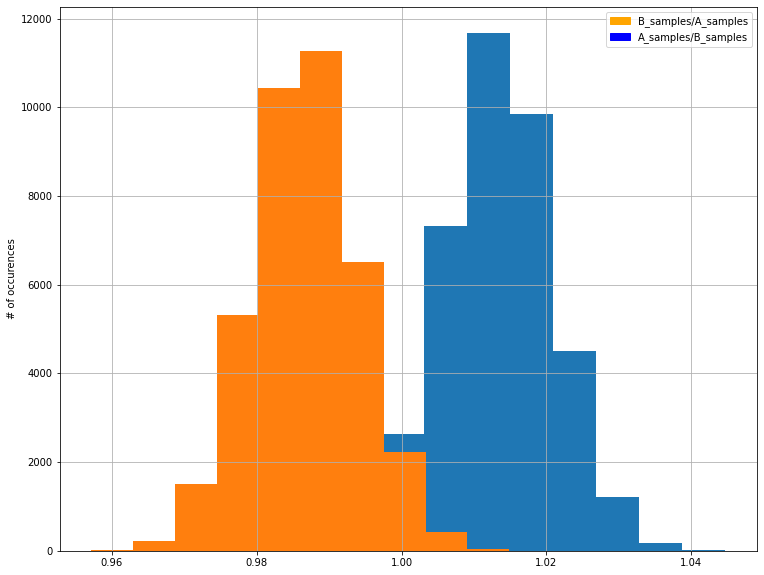

In [ ]:
# Calculate relative performance of A
orange_patch = mpatches.Patch(color='orange', label='B_samples/A_samples')
blue_patch = mpatches.Patch(color='blue', label='A_samples/B_samples')
A_relative = p_A_samples / p_B_samples
pd.Series(A_relative).hist()
plt.legend(handles=[orange_patch, blue_patch])
plt.ylabel('# of occurences')
# Calculate relative performance of B
B_relative = p_B_samples / p_A_samples
pd.Series(B_relative).hist()

### Retention rate after 7 days

In [ ]:
observations_A2 = df[df['version'] == 'gate_30']['retention_7'].values.astype(int)
observations_B2 = df[df['version'] == 'gate_40']['retention_7'].values.astype(int)
print(f'The number of users retained after 7 days in variant A: {observations_A2.sum()}')
print(f'The number of users retained after 7 days in variant B: {observations_B2.sum()}')

The number of users retained after 7 days in variant A: 8502
The number of users retained after 7 days in variant B: 8279


In [ ]:
#these two quantities are unknown to us.
true_p_A = 0.2
true_p_B = 0.18
# Set up the pymc3 model.
with pm.Model() as model2:
    p_A = pm.Beta("p_A", alpha=2.5, beta=8)
    p_B = pm.Beta("p_B", alpha=2.2, beta=8)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A2)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B2)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
100%|██████████| 20500/20500 [00:50<00:00, 408.96it/s]
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
p_A_samples2 = burned_trace["p_A"]
p_B_samples2 = burned_trace["p_B"]
delta_samples2 = burned_trace["delta"]

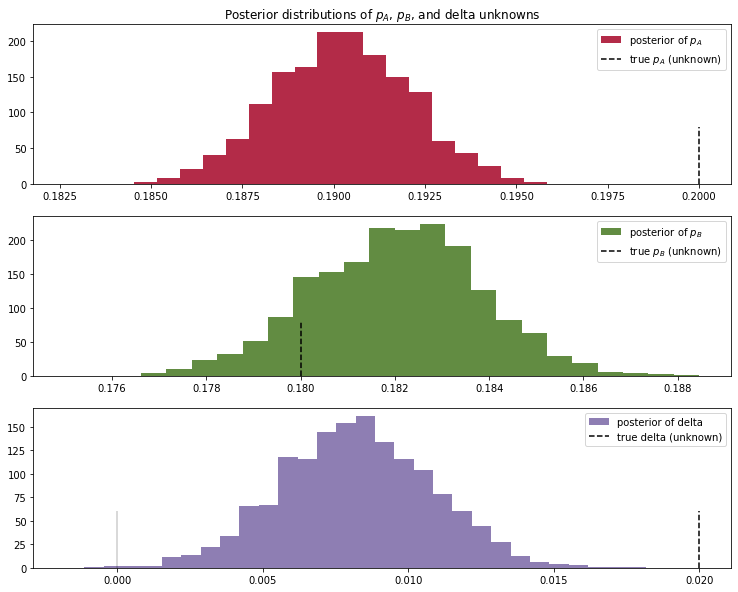

In [ ]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

# plt.xlim(0, .1)
plt.hist(p_A_samples2, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

# plt.xlim(0, .1)
plt.hist(p_B_samples2, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples2, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [ ]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples2 < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples2 > 0))

Probability site A is WORSE than site B: 0.001
Probability site A is BETTER than site B: 0.999


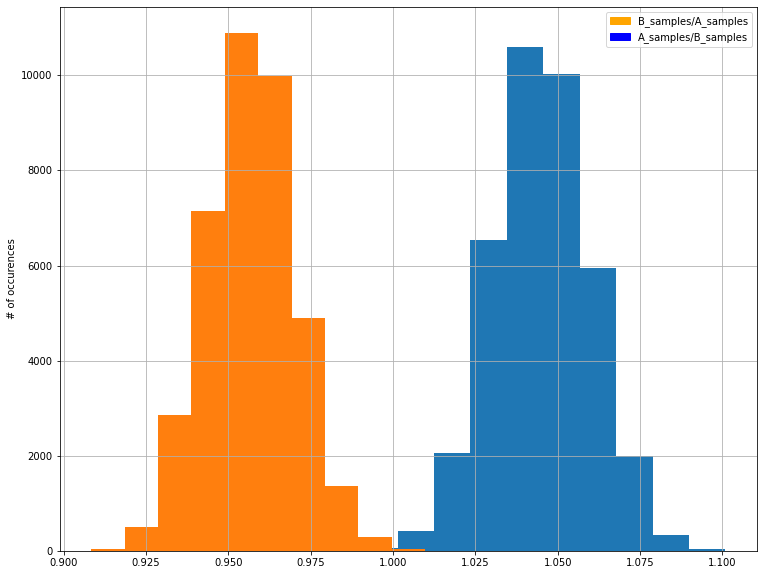

In [ ]:
# calculate relative performance of A
orange_patch = mpatches.Patch(color='orange', label='B_samples/A_samples')
blue_patch = mpatches.Patch(color='blue', label='A_samples/B_samples')
A_relative = p_A_samples2/p_B_samples2
pd.Series(A_relative).hist()
plt.legend(handles=[orange_patch,blue_patch])
plt.ylabel('# of occurences');
# calculate relative performance of B
B_relative = p_B_samples2/p_A_samples2
pd.Series(B_relative).hist();

This plot tells us that a 1.03-1.06x improvement from variant A is most likely

### Using fake data

In [ ]:
#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 30040
N_B = 30100
true_p_A = 0.40
true_p_B = 0.40
#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
#these two quantities are unknown to us.

# Set up the pymc3 model. Aassume Uniform priors for p_A and p_B.
with pm.Model() as model2:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)

    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets. 
    # These are the likelihoods using Bernoulli distribution
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
    burned_trace=trace[1000:]

p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
100%|██████████| 20500/20500 [00:42<00:00, 480.83it/s]
The number of effective samples is smaller than 10% for some parameters.


Probability site A is WORSE than site B: 0.632
Probability site A is BETTER than site B: 0.368


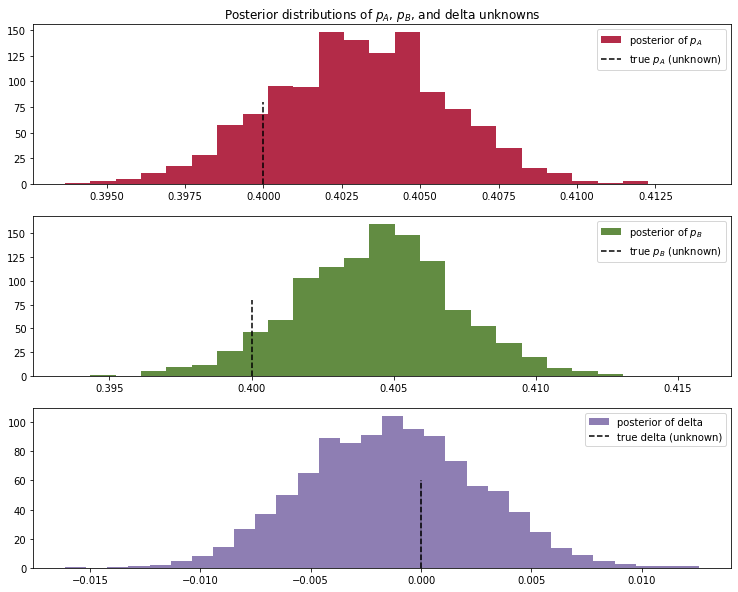

In [ ]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

# plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

# plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

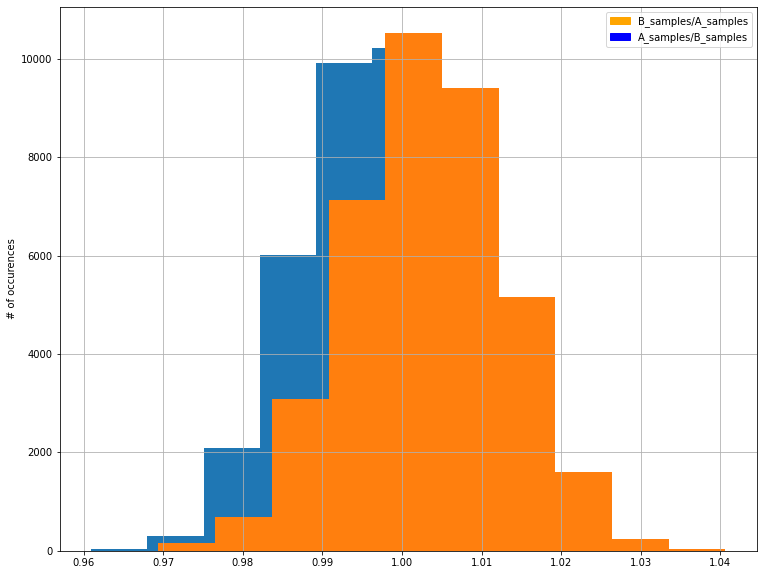

In [ ]:
# calculate relative performance of A
orange_patch = mpatches.Patch(color='orange', label='B_samples/A_samples')
blue_patch = mpatches.Patch(color='blue', label='A_samples/B_samples')
A_relative = p_A_samples/p_B_samples
pd.Series(A_relative).hist()
plt.legend(handles=[orange_patch,blue_patch])
plt.ylabel('# of occurences');
# calculate relative performance of B
B_relative = p_B_samples/p_A_samples
pd.Series(B_relative).hist();